In [777]:
# Imports libraries 
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import os
import mediapy as media
from tqdm import tqdm
import mujoco_viewer

# Robotics toolbox and dependencies
import roboticstoolbox as rtb
import spatialmath as sm
from spatialmath import UnitQuaternion, SE3
from spatialmath.base import q2r, r2x, rotx, roty, rotz, r2q, q2r
from mujoco_parser import MuJoCoParserClass

# Import local libraries
from Ur5e import Ur5e
from actuator import ActuatorMotor, update_actuator
from quaternion_helper import *

In [778]:
# Make ur5e instance
if 'ur5e' in locals():
    print('ur5e already exists')
    del ur5e

try:
    ur5e
except NameError:
    print('ur5e does not exist')
    ur5e = Ur5e()

ur5e already exists
ur5e does not exist


In [779]:
# Make actuator instance torque controlled
try:
    actuator
except NameError:
    actuator = ActuatorMotor()

torques_ctrl_range = np.array([[-150, 150], [-150, 150], [-150, 150], [-28, 28], [-28, 28], [-28, 28]])

for actuator_id in range(ur5e.m.nu):
    update_actuator(ur5e.m, actuator_id, actuator, ctrlrange=torques_ctrl_range[actuator_id])

In [780]:
# Visualize mujoco, Show initial state of the scene

# Use forward dynamics to get the initial state of the data
mujoco.mj_forward(ur5e.m, ur5e.d)
# render the initial state
if 'renderer' in locals():
    print('renderer already exists')
    del renderer


try:
    renderer
except NameError:
    renderer = mujoco.Renderer(ur5e.m, 480, 640)


#renderer.update_scene(ur5e.d, camera="fixed", scene_option=dict())
# show image
#media.show_image(renderer.render())

renderer already exists


# Trajectory

In [781]:
poi = np.array([
    [500, 550],
    [130, 243],
    [130, 223],
    [175, 223],
    [175, 263],
    [130, 263],
    [130, 223],
    [175, 223],
    [175, 243],
    [213, 243],
    [213, 223],
    [254, 223],
    [254, 164],
    [334, 164],
    [334, 144],
    [379, 144],
    [379, 184],
    [334, 184],
    [334, 144],
    
])

poi = poi + np.array([0, -280])

print(poi)
#plt.plot(poi[:, 0], poi[:, 1])
#plt.show()

'''
    [379, 144],
    [379, 164],
    [663, 164],
    [663, 271],
    [648, 271],
    [648, 289],
    [663, 289],
    [663, 392],
    [379, 392],
    [379, 372],
    [334, 372],
    [334, 412],
    [379, 412],
    [379, 372],
    [334, 372],
    [334, 392],
    [254, 392],
    [254, 339],
    [213, 339],
    [213, 319],
    [175, 319],
    [175, 339],
    [130, 339],
    [130, 319],
    [93, 319],
    [130, 319],
    [130, 299],
    [175, 299],
    [175, 319],
    [213, 319],
    [213, 299],
    [297, 299],
    [297, 339],
    [213, 339],
    [213, 299],
    [297, 299],
    [297, 319],
    [334, 319],
    [334, 299],
    [379, 299],
    [379, 339],
    [334, 339],
    [334, 299],
    [379, 299],
    [379, 319],
    [435, 319],
    [435, 292],
    [444, 281],
    [480, 281],
    [480, 261],
    [525, 261],
    [525, 281],
    [565, 281],
    [565, 301],
    [648, 301],
    [648, 261],
    [565, 261],
    [565, 281],
    [525, 281],
    [525, 301],
    [480, 301],
    [480, 281],
    [444, 281],
    [435, 272],
    [425, 281],
    [435, 292],
    [444, 281],
    [435, 272],
    [435, 243],
    [379, 243],
    [379, 263],
    [334, 263],
    [334, 243],
    [297, 243],
    [297, 263],
    [213, 263],
    [213, 223],
    [297, 223],
    [297, 243],
    [334, 243],
    [334, 223],
    [379, 223],
    [379, 243]
    '''

[[ 500  270]
 [ 130  -37]
 [ 130  -57]
 [ 175  -57]
 [ 175  -17]
 [ 130  -17]
 [ 130  -57]
 [ 175  -57]
 [ 175  -37]
 [ 213  -37]
 [ 213  -57]
 [ 254  -57]
 [ 254 -116]
 [ 334 -116]
 [ 334 -136]
 [ 379 -136]
 [ 379  -96]
 [ 334  -96]
 [ 334 -136]]


'\n    [379, 144],\n    [379, 164],\n    [663, 164],\n    [663, 271],\n    [648, 271],\n    [648, 289],\n    [663, 289],\n    [663, 392],\n    [379, 392],\n    [379, 372],\n    [334, 372],\n    [334, 412],\n    [379, 412],\n    [379, 372],\n    [334, 372],\n    [334, 392],\n    [254, 392],\n    [254, 339],\n    [213, 339],\n    [213, 319],\n    [175, 319],\n    [175, 339],\n    [130, 339],\n    [130, 319],\n    [93, 319],\n    [130, 319],\n    [130, 299],\n    [175, 299],\n    [175, 319],\n    [213, 319],\n    [213, 299],\n    [297, 299],\n    [297, 339],\n    [213, 339],\n    [213, 299],\n    [297, 299],\n    [297, 319],\n    [334, 319],\n    [334, 299],\n    [379, 299],\n    [379, 339],\n    [334, 339],\n    [334, 299],\n    [379, 299],\n    [379, 319],\n    [435, 319],\n    [435, 292],\n    [444, 281],\n    [480, 281],\n    [480, 261],\n    [525, 261],\n    [525, 281],\n    [565, 281],\n    [565, 301],\n    [648, 301],\n    [648, 261],\n    [565, 261],\n    [565, 281],\n    [525, 28

In [782]:
# Generate trajectory

#startpos = np.array([0, 0, 0])
T0 = sm.SE3.Trans(0.0, 0, 0.4) * sm.SE3.RPY([0, np.pi, 0]) # sm.SE3.Trans(0.5, 0, 0.3) * sm.SE3.RPY([0, np.pi, 0]) changed z from 0.3 to 0.4 to avoid collision
T1 = sm.SE3.Trans(0.0, 0, 0.4) * sm.SE3.RPY([0, np.pi, 0])
dt = 0.002 
endTime = 0.3
n = int(endTime/dt)

if 'ctr' not in locals():
    ctr = np.array([])
    times = np.array([])
    startTime = 0
    scalingX = 5000
    scalingY = 2500
    movementX = 0.4
    movementY = 0.0



    for i in tqdm(range(0, poi.shape[0]-1)):
        distance = np.sqrt((poi[i+1, 0] - poi[i, 0])**2 + (poi[i+1, 1] - poi[i, 1])**2)
        endTime = distance*0.05
        n = int(endTime/dt)
        T0.t[0] = movementX + poi[i, 0]/scalingX
        T0.t[1] = movementY + poi[i, 1]/scalingY
        T1.t[0] = movementX + poi[i+1, 0]/scalingX
        T1.t[1] = movementY + poi[i+1, 1]/scalingY
        trajectory = rtb.ctraj(T0, T1, n)
        time = np.linspace(startTime, startTime+endTime, n)
        startTime = startTime+endTime
        if i == 0:
            ctr = trajectory
            times = time
        else:
            x = ctr.Alloc(len(ctr)+len(trajectory))
            for j in range(0, len(ctr)):
                x[j] = ctr[j]
            for j in range(0, len(trajectory)):
                x[j+len(ctr)] = trajectory[j]
            ctr = x
            times = np.append(times, time)



    #differentiate to find velocity
    velocityX = np.gradient(ctr.t[:,0])
    velocityY = np.gradient(ctr.t[:,1])
    velocityZ = np.gradient(ctr.t[:,2])
    ctr.t[:,2] += 10.1

    velocity = np.transpose(np.array([velocityX, velocityY, velocityZ]))

    #differentiate to find acceleration
    accelerationX  = np.gradient(velocityX)
    accelerationY  = np.gradient(velocityY)
    accelerationZ  = np.gradient(velocityZ)

    acceleration = np.transpose(np.array([accelerationX, accelerationY, accelerationZ]))        
    print(f"No of points in trajectory: {len(ctr)}") 

In [783]:
'''
# Visualize trajectory
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.plot(ctr.t[:,0], ctr.t[:,1])
axs.set_title("Trajectory in XY plane")
axs.set_aspect(1)



fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.suptitle('Pos, Velocity and Acceleration in X direction')
axs[0].plot(times, ctr.t[:,0])
axs[0].set_title('Position in X direction')
axs[1].plot(times, velocity[:,0])
axs[1].set_title('Velocity in X direction')
axs[2].plot(times, acceleration[:,0])
axs[2].set_title('Acceleration in X direction')

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.suptitle('Pos, Velocity and Acceleration in Y direction')
axs[0].plot(times, ctr.t[:,1])
axs[0].set_title('Position in Y direction')
axs[1].plot(times, velocity[:,1])
axs[1].set_title('Velocity in Y direction')
axs[2].plot(times, acceleration[:,1])
axs[2].set_title('Acceleration in Y direction')'''




'\n# Visualize trajectory\nfig, axs = plt.subplots(1, 1, figsize=(10, 10))\naxs.plot(ctr.t[:,0], ctr.t[:,1])\naxs.set_title("Trajectory in XY plane")\naxs.set_aspect(1)\n\n\n\nfig, axs = plt.subplots(3, 1, figsize=(10, 10))\nfig.suptitle(\'Pos, Velocity and Acceleration in X direction\')\naxs[0].plot(times, ctr.t[:,0])\naxs[0].set_title(\'Position in X direction\')\naxs[1].plot(times, velocity[:,0])\naxs[1].set_title(\'Velocity in X direction\')\naxs[2].plot(times, acceleration[:,0])\naxs[2].set_title(\'Acceleration in X direction\')\n\nfig, axs = plt.subplots(3, 1, figsize=(10, 10))\nfig.suptitle(\'Pos, Velocity and Acceleration in Y direction\')\naxs[0].plot(times, ctr.t[:,1])\naxs[0].set_title(\'Position in Y direction\')\naxs[1].plot(times, velocity[:,1])\naxs[1].set_title(\'Velocity in Y direction\')\naxs[2].plot(times, acceleration[:,1])\naxs[2].set_title(\'Acceleration in Y direction\')'

[ 0.46363023 -1.63647607 -1.85964948 -1.21626343  1.57079632  2.03442655]


""

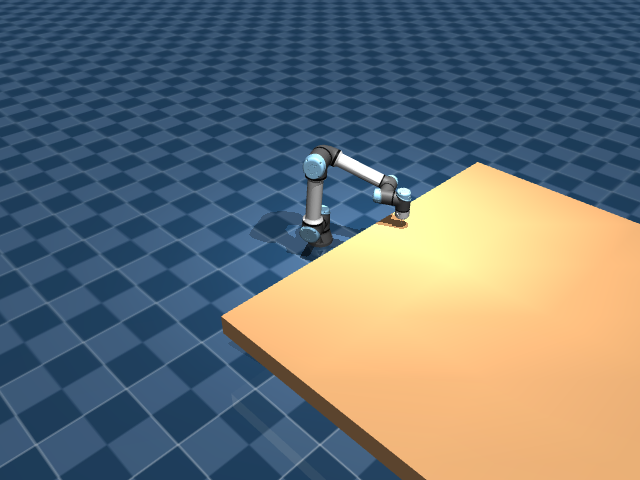

In [794]:
# Use the inverse kinematics to make a start pose for the robot
#ctr[0] = ctr[0] + np.array([0, 1, 0])
sol = ur5e.invkin(ctr[0])
print(sol.q)
#sol.q = sol.q + np.array([0, 0, 0, 0, 0, 0])
#print(sol.q + np.array([0, 0, 1, 0, 0, 0]))
# visualize the position
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)
renderer.update_scene(ur5e.d, camera="fixed", scene_option=dict())
# show image
media.show_image(renderer.render())
# joints pose
#[ 0.46362935 -1.63647675 -1.8596509  -1.2162613   1.57079635  2.03442568] # CBF

# Admittance Controller
More like an impedance controller, doesnt follow a trajectory but complies with environment

In [795]:
import numpy as np
import mujoco
from tqdm import tqdm


# Define Admittance Control Matrices
M_diag = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])  # Reduce mass in Z for faster descent
D_diag = np.array([50, 50, 50, 10, 10, 10])  # Reduce damping for less resistance
K_diag = np.array([0, 0, 0, 0, 0, 0])  # Stiffness matrix (set to zero for full admittance)


M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

# Compliance parameters
#deathband_force = 2.0
#deathband_torque = 0.15
compliance_vector = np.array([1, 1, 1, 1, 1, 1])

# Initialize error terms
x_e = np.zeros(6)  # Position error
v_e = np.zeros(6)  # Velocity error
v_e_last = np.zeros(6)  # Previous velocity

showVideo = True
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep
n_steps = int(np.ceil(duration / stepsize))
# Logging and video capture
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
torques = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
time_log = []
force_log = []  # to store the first 3 components of the external force


# Reset MuJoCo Simulation
#sol = np.array([0.27174445, -1.40474226, -2.07800756, -1.2296391, 1.57079635, 1.84254078])
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
#sol.qvel[:] = 0.0
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # Get Cartesian position and Jacobian
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    
    # Get force at the end effector
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    #f_ext[2] = -0.05  # Add gravity force
    
    # Apply compliance selection
    f_ext *= compliance_vector
    
    # Admittance Dynamics: Compute acceleration in Cartesian Space
    acc_e = np.linalg.inv(M) @ (f_ext - K @ x_e - D @ v_e)
    # Integrate velocity and position error
    v_e = (stepsize * 0.5) * (acc_e + v_e_last) + v_e_last
    x_e = (stepsize * 0.5) * (v_e + v_e_last) + x_e
    v_e_last = v_e.copy()
    
    # Compute target acceleration in joint space
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel)
    
    # Compute torque using inverse dynamics
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    torque_cmd = ur5e.d.qfrc_inverse.copy()
    ur5e.d.qacc[:] = prev_qacc
    
    # Apply torque control
    ur5e.d.ctrl[:] = torque_cmd
    
    # Log data
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate([tcp_pos.t, tcp_pos.rpy(order='xyz')])
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    torques[idx] = torque_cmd
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # Capture video frames
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    # Step simulation
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Show video
if showVideo:
    media.show_video(frames, fps=framerate)


 10%|█         | 0.5140000000000003/5 [00:10<01:27, 19.52s/it]
100%|█████████▉| 4.999999999999671/5 [00:09<00:00,  1.88s/it]


# Plots

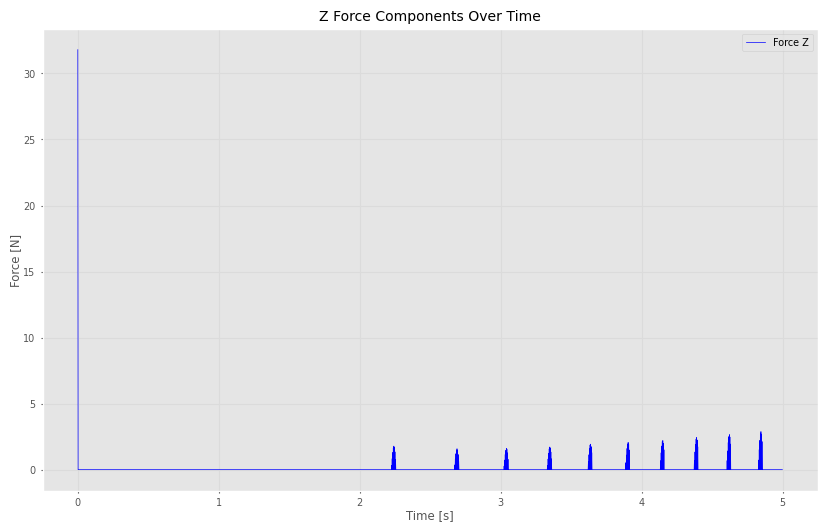

"\nplt.figure(figsize=(10, 6))\nplt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')\nplt.xlabel('Time [s]')\nplt.ylabel('Force Magnitude [N]')\nplt.title('Contact Force Magnitude Over Time')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [796]:
# Convert logs to NumPy arrays
time_log = np.array(time_log)          # shape: (n_steps,)
force_log = np.array(force_log)        # shape: (n_steps, 3)

# Optionally, compute the overall magnitude of the force vector at each step
force_magnitude = np.linalg.norm(force_log, axis=1)
plt.figure(figsize=(10, 6))
#plt.plot(time_log, force_log[:, 0], label='Force X', color='r')
#plt.plot(time_log, force_log[:, 1], label='Force Y', color='g')
plt.plot(time_log, force_log[:, 2], label='Force Z', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Z Force Components Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')
plt.xlabel('Time [s]')
plt.ylabel('Force Magnitude [N]')
plt.title('Contact Force Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''

# Torque plots

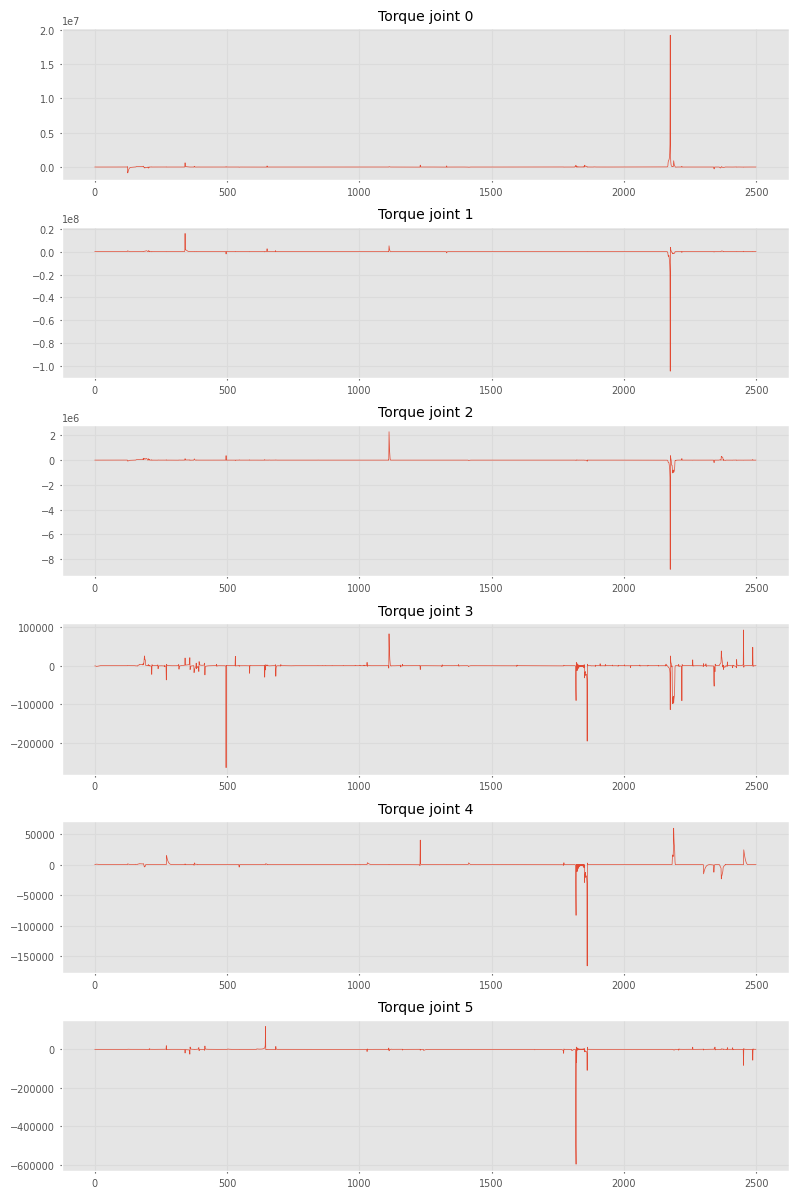

In [787]:

fig, axs = plt.subplots(6, 1, figsize=(8, 12))

axs[0].plot(torques[:,0])
axs[0].set_title('Torque joint 0')

axs[1].plot(torques[:,1])
axs[1].set_title('Torque joint 1')

axs[2].plot(torques[:,2])
axs[2].set_title('Torque joint 2')

axs[3].plot(torques[:,3])
axs[3].set_title('Torque joint 3')

axs[4].plot(torques[:,4])
axs[4].set_title('Torque joint 4')

axs[5].plot(torques[:,5])
axs[5].set_title('Torque joint 5')

plt.tight_layout()
plt.show()



# Admittance controller with CBF

In [797]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Set cvxopt options ---
solvers.options['show_progress'] = False

# --- Admittance Controller Parameters ---
M_diag = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])
D_diag = np.array([50, 50, 50, 10, 10, 10])
K_diag = np.array([100, 100, 100, 5, 5, 5])
M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

# --- Maximum Torque Limits for Each Joint ---
# (These values are different for each joint.)
MAX_TORQUE = np.array([150.0, 30.0, 25.0, 28.0, 28.0, 28.0])

# --- Compliance Vector (if using external force scaling) ---
compliance_vector = np.array([1, 1, 1, 1, 1, 1])

# --- Initialize Admittance State Variables ---
x_e = np.zeros(6)  # Cartesian position error
v_e = np.zeros(6)  # Cartesian velocity error
v_e_last = np.zeros(6)

# --- Simulation and Logging Parameters ---
showVideo = True
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep  # Simulation time step
n_steps = int(np.ceil(duration / stepsize))

# Logging arrays for kinematics and torques:
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
# We log the nominal torques and safe (QP-filtered) torques:
tau_nom_log = np.zeros((n_steps, 6))
tau_safe_log = np.zeros((n_steps, 6))
# And we log the barrier function h = MAX_TORQUE - tau_safe:
h_log = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
time_log = []
force_log = []  # log external force (first 3 components)

# --- Reset MuJoCo Simulation and Set Initial Configuration ---
# (Assuming sol.q contains your initial joint configuration.)
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # 1. cartesian kinematics
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    
    # 2. external force at end-effector
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    f_ext *= compliance_vector
    
    # 3. admittance Dynamics - get desired cartesian acceleration.
    acc_e = np.linalg.inv(M) @ (f_ext - K @ x_e - D @ v_e)
    
    # trapezoidal integration.
    v_e = v_e + stepsize * 0.5 * (acc_e + v_e_last)
    x_e = x_e + stepsize * 0.5 * (v_e + v_e_last)
    v_e_last = v_e.copy()
    
    # 4. cartesian to joint acc
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel)
    
    # 5. get nominal joint torques via inverse dynamics.
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    tau_nom = ur5e.d.qfrc_inverse.copy()  # nominal torque command
    ur5e.d.qacc[:] = prev_qacc
    
    # Log the nominal torques
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Safety Filtering: Enforce maximum torque constraint using a QP.
    # We solve for tau ∈ ℝ⁶:
    #    minimize   0.5 * ||tau - tau_nom||²
    #    subject to tau_i <= MAX_TORQUE[i] for each joint i.
    # This QP is formulated over the full 6D torque vector.
    P = matrix(np.eye(6))
    q_vec = matrix(-tau_nom)
    # The constraints: tau_i <= MAX_TORQUE[i]  ⟺  I * tau <= MAX_TORQUE.
    G = matrix(np.eye(6))
    h_vec = matrix(MAX_TORQUE)
    sol_qp = solvers.qp(P, q_vec, G, h_vec)
    tau_safe = np.array(sol_qp['x']).flatten()
    tau_safe_log[idx, :] = tau_safe.copy()
    
    # barrier function
    # h = tau_max - tau_safe = 0 at boundary
    h_log[idx, :] = MAX_TORQUE - tau_safe
    
    ur5e.d.ctrl[:] = tau_safe
    
    # Log
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Optionally display video
if showVideo:
    media.show_video(frames, fps=framerate)

# -------------------------------


100%|█████████▉| 4.999999999999671/5 [00:10<00:00,  2.11s/it]  


# Plots

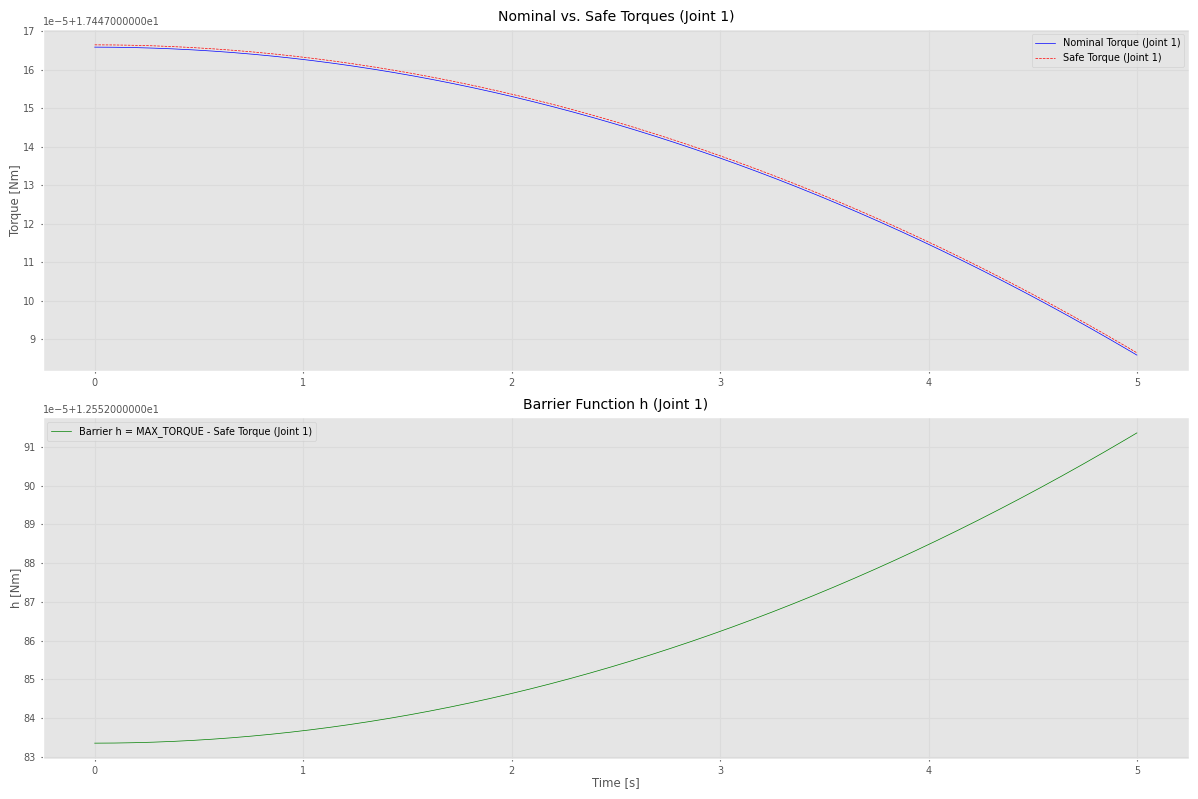

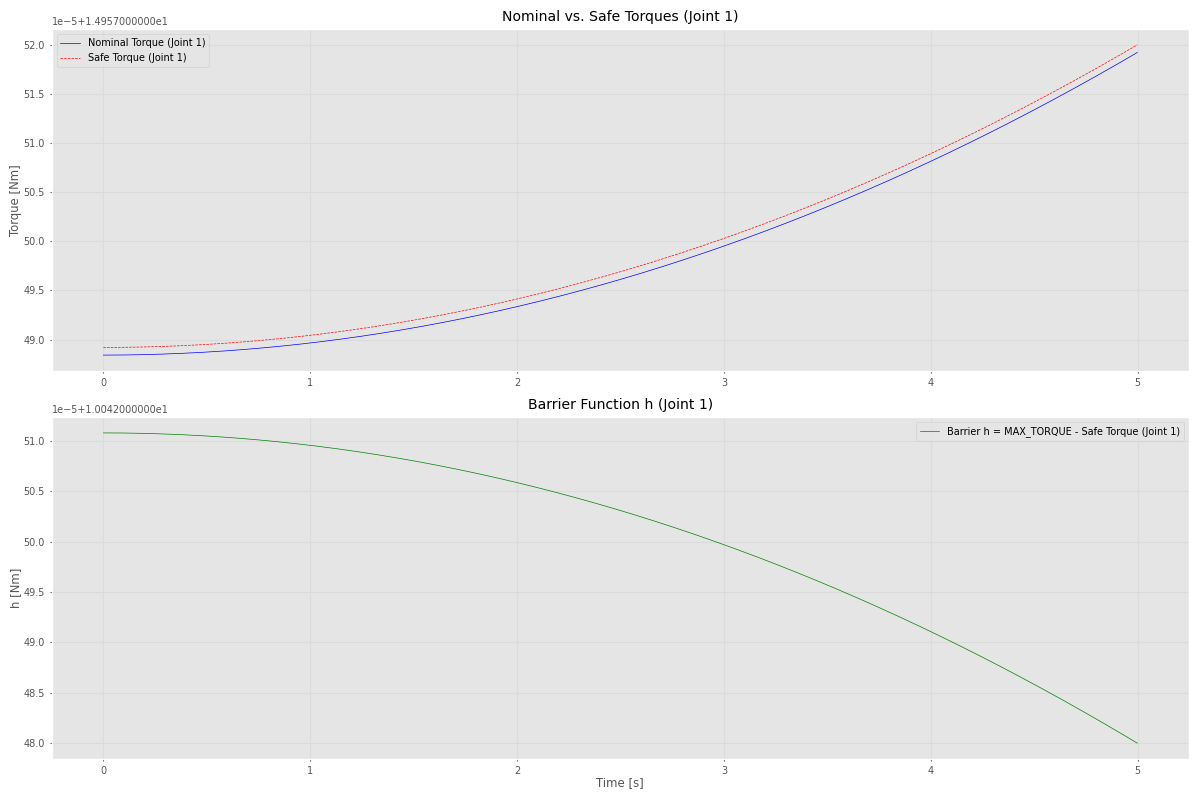

In [ ]:
# Plotting: Nominal Torques, Safe Torques, and Barrier Function h
# -------------------------------
time_array = np.array(time_log)

# For demonstration, we plot data for joint 1 (index 0). You can extend to all joints.
plt.figure(figsize=(12, 8))

# Plot nominal and safe torques for joint 1
plt.subplot(2,1,1)
plt.plot(time_array, tau_nom_log[:,1], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_safe_log[:,1], 'r--', label='Safe Torque (Joint 1)')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. Safe Torques (Joint 1)')
plt.legend()
plt.grid(True)

# Plot barrier function h for joint 1: h = MAX_TORQUE[0] - safe torque.
plt.subplot(2,1,2)
plt.plot(time_array, h_log[:,1], 'g-', label='Barrier h = MAX_TORQUE - Safe Torque (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('h [Nm]')
plt.title('Barrier Function h (Joint 1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# For demonstration, we plot data for joint 1 (index 0). You can extend to all joints.
plt.figure(figsize=(12, 8))

# Plot nominal and safe torques for joint 1
plt.subplot(2,1,1)
plt.plot(time_array, tau_nom_log[:,2], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_safe_log[:,2], 'r--', label='Safe Torque (Joint 1)')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. Safe Torques (Joint 1)')
plt.legend()
plt.grid(True)

# Plot barrier function h for joint 1: h = MAX_TORQUE[0] - safe torque.
plt.subplot(2,1,2)
plt.plot(time_array, h_log[:,2], 'g-', label='Barrier h = MAX_TORQUE - Safe Torque (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('h [Nm]')
plt.title('Barrier Function h (Joint 1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Torque plots

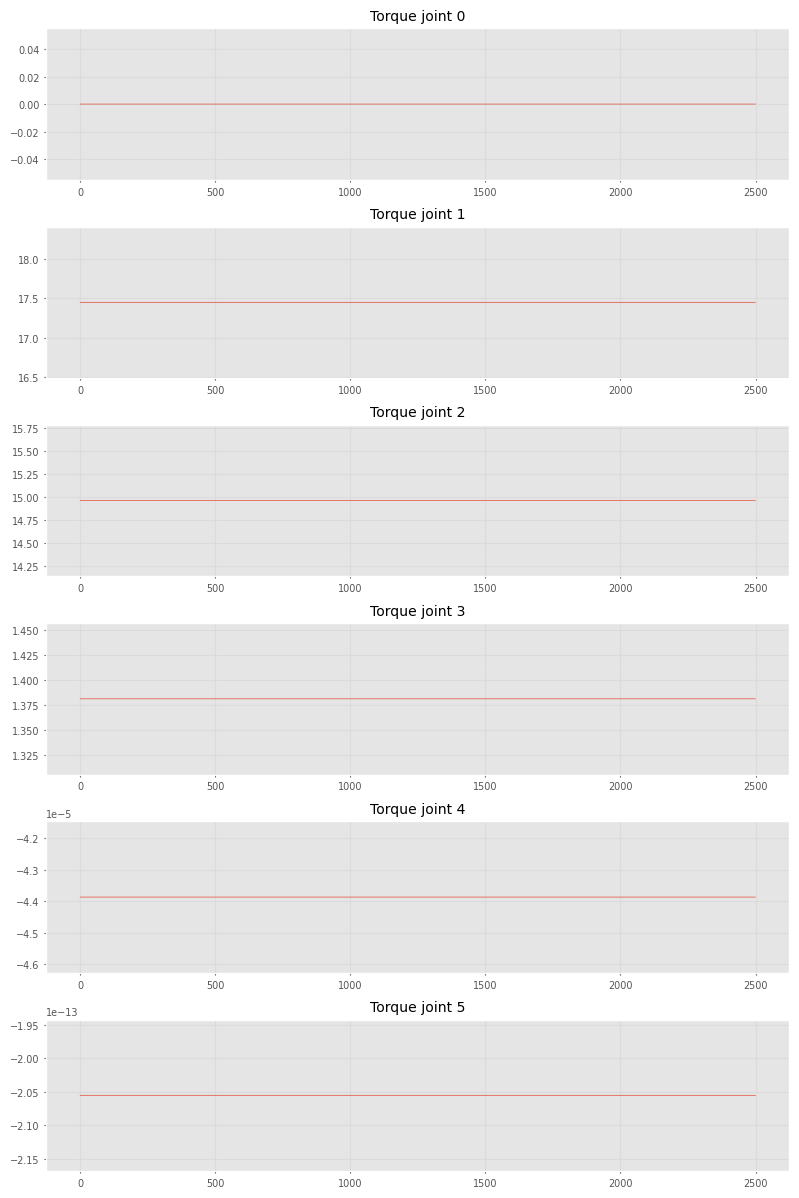

In [ ]:

fig, axs = plt.subplots(6, 1, figsize=(8, 12))

axs[0].plot(torques[:,0])
axs[0].set_title('Torque joint 0')

axs[1].plot(torques[:,1])
axs[1].set_title('Torque joint 1')

axs[2].plot(torques[:,2])
axs[2].set_title('Torque joint 2')

axs[3].plot(torques[:,3])
axs[3].set_title('Torque joint 3')

axs[4].plot(torques[:,4])
axs[4].set_title('Torque joint 4')

axs[5].plot(torques[:,5])
axs[5].set_title('Torque joint 5')

plt.tight_layout()
plt.show()



# Traditional CBF with L_f h(x), L_g h(x) and alpha

In [ ]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Set cvxopt options ---
solvers.options['show_progress'] = False

# -------------------------------------------------------------------
# Admittance Controller Parameters (Cartesian)
# -------------------------------------------------------------------
M_diag = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])
D_diag = np.array([5, 5, 5, 10, 10, 10])
K_diag = np.array([10, 10, 10, 5, 5, 5])
M_cart = np.diag(M_diag)
D_cart = np.diag(D_diag)
K_cart = np.diag(K_diag)

# -------------------------------------------------------------------
# Define a simple barrier function on joint states.
# We choose a safe threshold for each joint.
# For example, assume we want each joint to be above 0 (modify as needed).
# -------------------------------------------------------------------
q_safe = np.array([-20.0, -20.0, -20.0, -20.0, -20.0, -20.0])
lambda_cbf = 10.0  # CBF rate parameter (1/s)

# -------------------------------------------------------------------
# Other parameters
# -------------------------------------------------------------------
# Maximum torque limits (if desired, these can still be enforced separately)
#MAX_TORQUE = np.array([1.0, 27.0, 23.0, 28.0, 28.0, 28.0])
# Compliance vector (if scaling external forces)
compliance_vector = np.array([1, 1, 1, 1, 1, 1])

# -------------------------------------------------------------------
# Initialize Admittance State Variables (Cartesian)
# -------------------------------------------------------------------
x_e = np.zeros(6)  # Cartesian position error
v_e = np.zeros(6)  # Cartesian velocity error
v_e_last = np.zeros(6)

# -------------------------------------------------------------------
# Simulation and Logging Parameters
# -------------------------------------------------------------------
showVideo = True
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep  # Simulation time step (Δt)
n_steps = int(np.ceil(duration / stepsize))

# Logging arrays:
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
# Log nominal torques and CBF-filtered torques:
tau_nom_log = np.zeros((n_steps, 6))
tau_cbf_log = np.zeros((n_steps, 6))
# Log barrier function values (here we log h = q - q_safe)
h_log = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
time_log = []
force_log = []  # log external force (first 3 components)
q_log = np.zeros((n_steps, 6))  # 6 joints


# -------------------------------------------------------------------
# Reset MuJoCo Simulation and Set Initial Configuration
# -------------------------------------------------------------------
# (Assuming sol.q contains your initial joint configuration)
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # 1. Get Cartesian kinematics: end-effector pose, Jacobian, and its derivative.
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    q_log[idx, :] = ur5e.d.qpos.copy()  # log all joint positions
    # 2. Get external force (if any)
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    f_ext *= compliance_vector
    
    # 3. Admittance Dynamics: compute desired Cartesian acceleration.
    acc_e = np.linalg.inv(M_cart) @ (f_ext - K_cart @ x_e - D_cart @ v_e)
    
    # Integrate acceleration (trapezoidal integration)
    v_e = v_e + stepsize * 0.5 * (acc_e + v_e_last)
    x_e = x_e + stepsize * 0.5 * (v_e + v_e_last)
    v_e_last = v_e.copy()
    
    # 4. Map Cartesian acceleration to joint acceleration.
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel)
    
    # 5. Compute nominal joint torques via inverse dynamics.
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    tau_nom = ur5e.d.qfrc_inverse.copy()  # Nominal torque command
    ur5e.d.qacc[:] = prev_qacc
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Safety Filtering via the CBF.
    # For each joint i, our barrier function is:
    #   h_i = q_i - q_safe[i].
    # We want to ensure in discrete time that
    #   q_dot_i + λ (q_i - q_safe[i]) >= 0.
    # Approximating one step ahead:
    #   q_dot_i_new ≈ q_dot_i + stepsize * τ_i,
    # we require:
    #   q_dot_i + stepsize * τ_i + λ (q_i - q_safe[i]) ≥ 0.
    # Solving for τ_i gives:
    #   τ_i ≥ - (q_dot_i + λ (q_i - q_safe[i])) / stepsize.
    tau_cbf = np.zeros(6)
    q = ur5e.d.qpos[:]    # Current joint positions
    q_dot = ur5e.d.qvel[:]  # Current joint velocities
    for i in range(6):
        L_bound = - (q_dot[i] + lambda_cbf * (q[i] - q_safe[i])) / stepsize
        # Solve a 1D QP: minimize 0.5*(τ - τ_nom[i])² subject to τ >= L_bound.
        # (In one dimension the solution is simply τ = max(τ_nom[i], L_bound).)
        P = matrix(np.array([[1.0]]))
        q_vec = matrix(np.array([-tau_nom[i]]))
        G = matrix(np.array([[-1.0]]))  # -τ_i <= -L_bound  ⟺  τ_i ≥ L_bound
        h_qp = matrix(np.array([-L_bound]))
        sol_qp = solvers.qp(P, q_vec, G, h_qp)
        if sol_qp['status'] == 'optimal':
            tau_cbf[i] = sol_qp['x'][0]
        else:
            tau_cbf[i] = tau_nom[i]
    tau_cbf_log[idx, :] = tau_cbf.copy()
    
    # 7. Log the barrier function values: h = q - q_safe.
    h_log[idx, :] = q - q_safe
    
    # 8. Apply the CBF-modified (safety-filtered) torque command.
    ur5e.d.ctrl[:] = tau_cbf
    
    # 9. Logging kinematics and force data.
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # 10. Capture video frames (if needed)
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    # 11. Step the simulation.
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Optionally display video.
if showVideo:
    media.show_video(frames, fps=framerate)




100%|█████████▉| 4.999999999999671/5 [00:18<00:00,  3.63s/it]   


# Plots

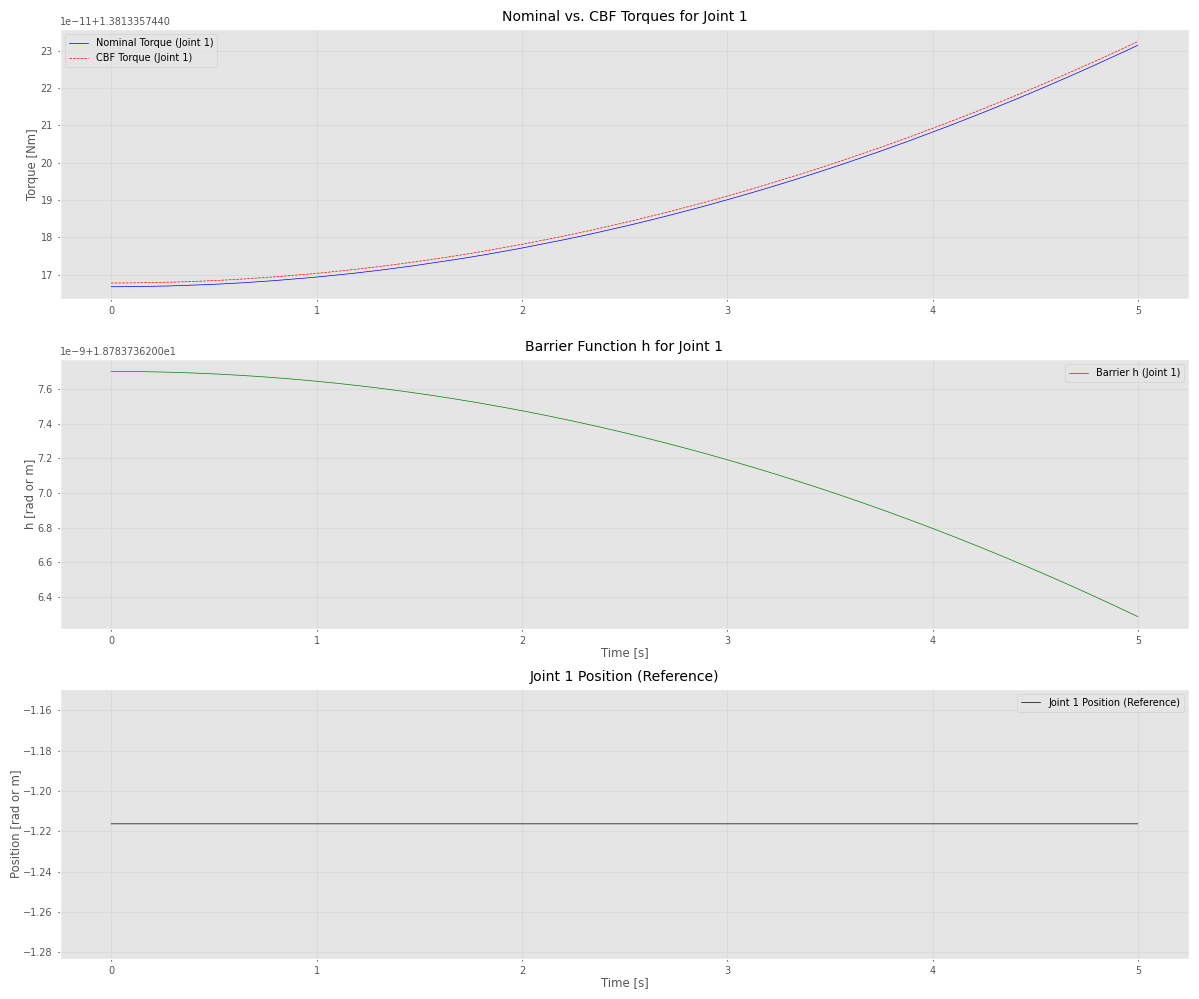

In [ ]:
# -------------------------------------------------------------------
# Plotting: Nominal vs. CBF Torques and the Barrier Function h for Joint 1
# -------------------------------------------------------------------
time_array = np.array(time_log)

plt.figure(figsize=(12, 10))

# Plot nominal and CBF torques for Joint 1 (index 0)
joint = 3
plt.subplot(3, 1, 1)
plt.plot(time_array, tau_nom_log[:, joint], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_cbf_log[:, joint], 'r--', label='CBF Torque (Joint 1)')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. CBF Torques for Joint 1')
plt.legend()
plt.grid(True)

# Plot the barrier function for Joint 1: h = q - q_safe.
plt.subplot(3, 1, 2)
plt.plot(time_array, h_log[:, joint], 'g-', label='Barrier h (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('h [rad or m]')
plt.title('Barrier Function h for Joint 1')
plt.legend()
plt.grid(True)

# For reference, plot Joint 1 position (assumed constant safe value)
plt.subplot(3, 1, 3)
plt.plot(time_array, ur5e.d.qpos[joint] * np.ones_like(time_array), 'k-', label='Joint 1 Position (Reference)')
plt.xlabel('Time [s]')
plt.ylabel('Position [rad or m]')
plt.title('Joint 1 Position (Reference)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

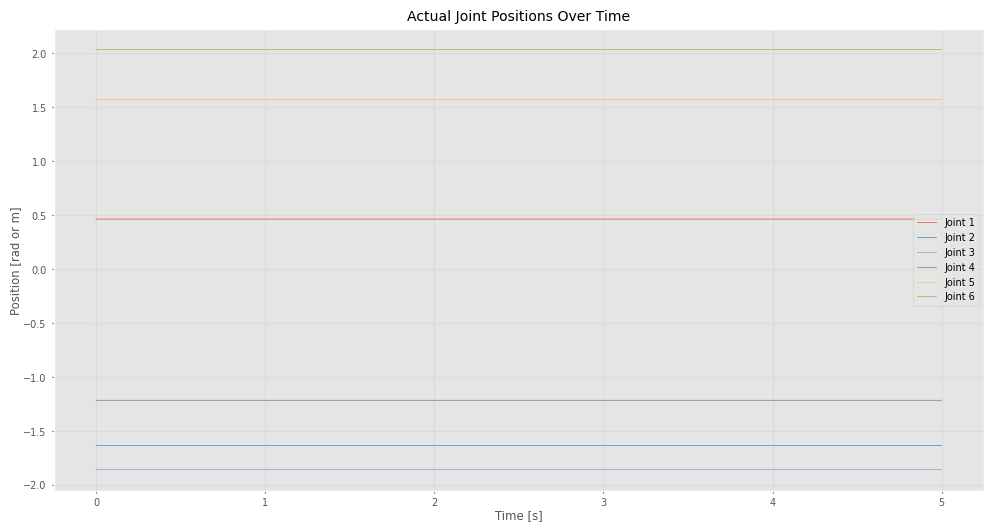

In [ ]:
time_array = np.array(time_log)  # assuming time_log is logged each step
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(time_array, q_log[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Position [rad or m]')
plt.title('Actual Joint Positions Over Time')
plt.legend()
plt.grid(True)
plt.show()



# CBF torque_Min and torque_max

In [ ]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Set cvxopt options ---
solvers.options['show_progress'] = False

# --- Admittance Controller Parameters ---
M_diag = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])
D_diag = np.array([50, 50, 50, 10, 10, 10])
K_diag = np.array([100, 100, 100, 5, 5, 5])
M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

# --- Torque Limits for Each Joint ---
MAX_TORQUE = np.array([0.1, 30.0, 25.0, 28.0, 28.0, 28.0])
MIN_TORQUE = np.array([-2.0, -27.0, -23.0, -28.0, -28.0, -28.0])

# --- Compliance Vector (if using external force scaling) ---
compliance_vector = np.array([1, 1, 1, 1, 1, 1])

# --- Initialize Admittance State Variables ---
x_e = np.zeros(6)  # Cartesian position error
v_e = np.zeros(6)  # Cartesian velocity error
v_e_last = np.zeros(6)

# --- Simulation and Logging Parameters ---
showVideo = True
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep  # Simulation time step
n_steps = int(np.ceil(duration / stepsize))

# Logging arrays for kinematics and torques:
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
# We log the nominal torques and the QP-filtered (CBF) torques:
tau_nom_log = np.zeros((n_steps, 6))
tau_cbf_log = np.zeros((n_steps, 6))
# And we log the barrier function h = MAX_TORQUE - tau_cbf:
h_log = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []
time_log = []
force_log = []  # log external force (first 3 components)

# --- Reset MuJoCo Simulation and Set Initial Configuration ---
# (Assuming sol.q contains your initial joint configuration.)
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # 1. Get Cartesian kinematics: end-effector pose, Jacobian, and its derivative.
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    
    # 2. Get external force (if any)
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    f_ext *= compliance_vector
    
    # 3. Admittance Dynamics: Compute desired Cartesian acceleration.
    acc_e = np.linalg.inv(M) @ (f_ext - K @ x_e - D @ v_e)
    
    # Integrate acceleration using trapezoidal integration.
    v_e = v_e + stepsize * 0.5 * (acc_e + v_e_last)
    x_e = x_e + stepsize * 0.5 * (v_e + v_e_last)
    v_e_last = v_e.copy()
    
    # 4. Map Cartesian acceleration to joint acceleration.
    acc_joint = np.linalg.pinv(J) @ (acc_e - dJ @ ur5e.d.qvel)
    
    # 5. Compute nominal joint torques via inverse dynamics.
    prev_qacc = ur5e.d.qacc.copy()
    ur5e.d.qacc[:] = acc_joint
    mujoco.mj_inverse(ur5e.m, ur5e.d)
    tau_nom = ur5e.d.qfrc_inverse.copy()  # nominal torque command
    ur5e.d.qacc[:] = prev_qacc
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Safety Filtering: Enforce both maximum and minimum torque constraints using a QP.
    #    We solve for tau ∈ ℝ⁶:
    #         minimize   0.5 * ||tau - tau_nom||²
    #         subject to MIN_TORQUE[i] <= tau_i <= MAX_TORQUE[i] for each joint i.
    # Formulated as:
    #    G*tau <= h, where we stack:
    #         tau_i <= MAX_TORQUE[i]        →   I*tau <= MAX_TORQUE
    #         -tau_i <= -MIN_TORQUE[i]      →  -I*tau <= -MIN_TORQUE
    P = matrix(np.eye(6))
    q_vec = matrix(-tau_nom)
    G = matrix(np.vstack((np.eye(6), -np.eye(6))))
    h_vec = matrix(np.hstack((MAX_TORQUE, -MIN_TORQUE)))
    sol_qp = solvers.qp(P, q_vec, G, h_vec)
    tau_cbf = np.array(sol_qp['x']).flatten()
    tau_cbf_log[idx, :] = tau_cbf.copy()
    
    # 7. Compute the barrier function for each joint as:
    #      h = MAX_TORQUE - tau_cbf.
    h_log[idx, :] = MAX_TORQUE - tau_cbf
    
    # 8. Apply the QP-filtered torque command.
    ur5e.d.ctrl[:] = tau_cbf
    
    # 9. Logging kinematics and force data.
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = f_ext[:3]
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # 10. Capture video frame (if needed)
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    # 11. Step the simulation.
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Optionally display video.
if showVideo:
    media.show_video(frames, fps=framerate)

# -------------------------------
# Plotting Nominal vs. CBF Torques and the Barrier Function h for Joint 1
# -------------------------------
time_array = np.array(time_log)

plt.figure(figsize=(12, 10))

# Plot nominal and CBF torques for Joint 1 (index 0)
plt.subplot(3, 1, 1)
plt.plot(time_array, tau_nom_log[:, 0], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_cbf_log[:, 0], 'r--', label='CBF Torque (Joint 1)')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. CBF Torques for Joint 1')
plt.legend()
plt.grid(True)

# Plot the barrier function h for Joint 1: h = MAX_TORQUE - tau_cbf.
plt.subplot(3, 1, 2)
plt.plot(time_array, h_log[:, 0], 'g-', label='Barrier Function h (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('h [Nm]')
plt.title('Barrier Function h for Joint 1')
plt.legend()
plt.grid(True)

# Plot Joint 1 position (for reference; here we assume constant initial value)
plt.subplot(3, 1, 3)
plt.plot(time_array, ur5e.d.qpos[0] * np.ones_like(time_array), 'k-', label='Joint 1 Position')
plt.xlabel('Time [s]')
plt.ylabel('Position [rad or m]')
plt.title('Joint 1 Position (Constant Initial Value)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


 20%|██        | 1.0040000000000007/5 [00:02<00:09,  2.36s/it] 

KeyboardInterrupt: 

# Admittance controller following trajectory
D=50,50,30,10,10,10

In [ ]:
import numpy as np
import mujoco
from tqdm import tqdm

# Define Admittance Control Matrices
M_diag = np.array([50.0, 50.0, 50.0, 2.0, 2.0, 2.0])  # Mass matrix for admittance control
D_diag = np.array([100, 100, 100, 5, 5, 5])  # Damping matrix
K_diag = np.array([100, 100, 100, 5, 5, 5])  # Stiffness for trajectory tracking

M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

MAX_TORQUE = np.array([150.0, 150.0, 150.0, 28.0, 28.0, 28.0])
time_log = []
force_log = []  # to store the first 3 components of the external force
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep
n_steps = int(np.ceil(duration / stepsize))
showVideo = True

# Logging and video capture
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 6))
torques = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []

# Generate a sinusoidal trajectory with downward motion
trajectory_amplitude = 0.04
trajectory_frequency = 0.1
z_velocity = -0.05  # Constant downward velocity
p = np.zeros((n_steps, 6))
dp = np.zeros((n_steps, 6))
ddp = np.zeros((n_steps, 6))

for i in range(n_steps):
    t = i * stepsize
    p[i, 0] = trajectory_amplitude * np.sin(2 * np.pi * trajectory_frequency * t)  # X motion
    dp[i, 0] = trajectory_amplitude * 2 * np.pi * trajectory_frequency * np.cos(2 * np.pi * trajectory_frequency * t)
    ddp[i, 0] = -trajectory_amplitude * (2 * np.pi * trajectory_frequency) ** 2 * np.sin(2 * np.pi * trajectory_frequency * t)
    
    p[i, 2] = z_velocity * t  # Downward motion in Z
    dp[i, 2] = z_velocity
    ddp[i, 2] = 0  # Constant velocity in Z means zero acceleration

# Reset MuJoCo Simulation
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # Get Cartesian position and Jacobian
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)

    # Get force at the end effector
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    
    # Apply compliance selection
    f_ext *= compliance_vector
    
    # Compute trajectory error
    target_pose = p[idx]
    error_in_base_frame = target_pose - np.concatenate([tcp_pos.t, np.zeros(3)])
    v_e = J @ ur5e.d.qvel
    
    # Admittance control: Compute desired acceleration
    acc_e = np.linalg.inv(M) @ (-D @ (v_e - dp[idx]) - K @ error_in_base_frame + ddp[idx])
    
    # Compute joint torques
    tau = J.T @ (M @ acc_e + D @ (dp[idx] - v_e) + K @ error_in_base_frame)
    mass_matrix = np.zeros((ur5e.m.nv, ur5e.m.nv))
    mujoco.mj_fullM(ur5e.m, mass_matrix, ur5e.d.qM)
    coriolis_forces = ur5e.d.qfrc_bias.copy()
    tau += mass_matrix @ ur5e.d.qacc + coriolis_forces
    
    # Clamp torques
    tau = np.clip(tau, -MAX_TORQUE, MAX_TORQUE)
    
    # Apply torque control
    ur5e.d.ctrl[:] = tau
    
    # Log data
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate([tcp_pos.t, tcp_pos.rpy(order='xyz')])
    velocities[idx] = v_e
    forces[idx] = M @ acc_e
    torques[idx] = tau
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # Capture video frames
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        #print(pixels.shape, pixels.dtype)
        frames.append(pixels)
    
    # Step simulation
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Show video
if showVideo:
    media.show_video(frames, fps=framerate)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████▉| 4.999999999999671/5 [00:09<00:00,  1.85s/it]  


# Plots

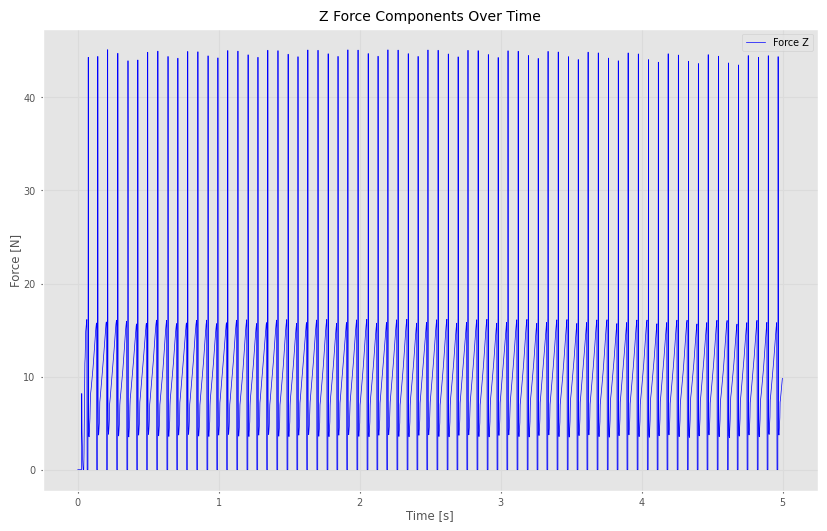

"\nplt.figure(figsize=(10, 6))\nplt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')\nplt.xlabel('Time [s]')\nplt.ylabel('Force Magnitude [N]')\nplt.title('Contact Force Magnitude Over Time')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [ ]:
# Convert logs to NumPy arrays
time_log = np.array(time_log)          # shape: (n_steps,)
force_log = np.array(force_log)        # shape: (n_steps, 3)

# Optionally, compute the overall magnitude of the force vector at each step
force_magnitude = np.linalg.norm(force_log, axis=1)
plt.figure(figsize=(10, 6))
#plt.plot(time_log, force_log[:, 0], label='Force X', color='r')
#plt.plot(time_log, force_log[:, 1], label='Force Y', color='g')
plt.plot(time_log, force_log[:, 2], label='Force Z', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Z Force Components Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')
plt.xlabel('Time [s]')
plt.ylabel('Force Magnitude [N]')
plt.title('Contact Force Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''

# Admittance following trajectory + CBF

In [ ]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Set cvxopt options ---
solvers.options['show_progress'] = False

# -------------------------------------------------------------------
# Admittance Controller Parameters (Cartesian)
# -------------------------------------------------------------------
M_diag = np.array([50.0, 50.0, 50.0, 12.0, 12.0, 12.0])  # Mass matrix for admittance control
D_diag = np.array([100, 100, 100, 25, 25, 25])            # Damping matrix
K_diag = np.array([100, 100, 100, 25, 25, 25])             # Stiffness for trajectory tracking

M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

# -------------------------------------------------------------------
# Torque Limits for Each Joint (for CBF filtering)
# -------------------------------------------------------------------
#MAX_TORQUE = np.array([0.0, 16.0, 12.5, 2.0, 2.0, 0.1])
#MIN_TORQUE = np.array([-1.5, 10.0, 10.0, -0.1, -0.5, -0.15])
MAX_TORQUE = np.array([150.0, 150.0, 150.0, 28.0, 28.0, 28.0])
MIN_TORQUE =  -MAX_TORQUE#np.array([-1.5, 10.0, 10.0, -0.1, -0.5, -0.15])

# -------------------------------------------------------------------
# Other Parameters and Logging Setup
# -------------------------------------------------------------------
time_log = []
force_log = []  # to store the first 3 components of the external force
duration = 5        # seconds
framerate = 30      # Hz
stepsize = ur5e.m.opt.timestep  # Simulation time step (Δt)
n_steps = int(np.ceil(duration / stepsize))
showVideo = True

# Logging arrays
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 6))
torques = np.zeros((n_steps, 6))        # safe torques (after QP)
tau_nom_log = np.zeros((n_steps, 6))      # nominal torques (before QP)
# We log a simple “barrier” value as MAX_TORQUE - tau_safe (for example)
h_log = np.zeros((n_steps, 6))
# Also log the actual joint positions (6 joints)
q_log = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []

# -------------------------------------------------------------------
# Trajectory Generation (Sinusoidal in X, constant downward in Z)
# -------------------------------------------------------------------
trajectory_amplitude = 0.04
trajectory_frequency = 0.1
z_velocity = -0.55  # Constant downward velocity
p = np.zeros((n_steps, 6))
dp = np.zeros((n_steps, 6))
ddp = np.zeros((n_steps, 6))

for i in range(n_steps):
    t = i * stepsize
    p[i, 0] = trajectory_amplitude * np.sin(2 * np.pi * trajectory_frequency * t)  # X motion
    dp[i, 0] = trajectory_amplitude * 2 * np.pi * trajectory_frequency * np.cos(2 * np.pi * trajectory_frequency * t)
    ddp[i, 0] = -trajectory_amplitude * (2 * np.pi * trajectory_frequency) ** 2 * np.sin(2 * np.pi * trajectory_frequency * t)
    
    p[i, 2] = z_velocity * t  # Downward motion in Z
    dp[i, 2] = z_velocity
    ddp[i, 2] = 0  # Constant velocity in Z → zero acceleration

# -------------------------------------------------------------------
# Reset MuJoCo Simulation and Set Initial Configuration
# -------------------------------------------------------------------
# (Assuming sol.q contains your initial joint configuration.)
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # 1. Get Cartesian kinematics: end-effector pose, Jacobian, and its derivative.
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    
    # 2. Get force at the end effector (if any).
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    
    # (For this example we assume compliance_vector = 1.)
    f_ext *= 1.0
    
    # 3. Compute trajectory error in Cartesian space.
    target_pose = p[idx]
    error_in_base_frame = target_pose - np.concatenate([tcp_pos.t, np.zeros(3)])
    v_e = J @ ur5e.d.qvel
    
    # 4. Admittance control: compute desired Cartesian acceleration.
    acc_e = np.linalg.inv(M) @ (-D @ (v_e - dp[idx]) - K @ error_in_base_frame + ddp[idx])
    
    # 5. Compute nominal joint torques via inverse dynamics.
    tau = J.T @ (M @ acc_e + D @ (dp[idx] - v_e) + K @ error_in_base_frame)
    mass_matrix = np.zeros((ur5e.m.nv, ur5e.m.nv))
    mujoco.mj_fullM(ur5e.m, mass_matrix, ur5e.d.qM)
    coriolis_forces = ur5e.d.qfrc_bias.copy()
    tau += mass_matrix @ ur5e.d.qacc + coriolis_forces
    tau_nom = tau.copy()  # nominal torque command
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Apply a QP to enforce both a maximum and a minimum torque limit.
    #    We solve:
    #       minimize   0.5 * ||τ - τ_nom||²
    #       subject to  MIN_TORQUE <= τ <= MAX_TORQUE.
    P = matrix(np.eye(6))
    q_vec = matrix(-tau_nom)
    # Stack constraints: τ <= MAX_TORQUE and -τ <= -MIN_TORQUE.
    G = matrix(np.vstack((np.eye(6), -np.eye(6))))
    h_vec = matrix(np.hstack((MAX_TORQUE, -MIN_TORQUE)))
    sol_qp = solvers.qp(P, q_vec, G, h_vec)
    tau_safe = np.array(sol_qp['x']).flatten()
    tau_cbf_log[idx, :] = tau_safe.copy()
    
    # 7. For logging, we define a barrier function as the difference from the upper limit:
    h_val = MAX_TORQUE - tau_safe
    h_log[idx, :] = h_val.copy()
    
    # 8. Apply the QP-filtered (safe) torque command.
    ur5e.d.ctrl[:] = tau_safe
    
    # 9. Log kinematics.
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = M @ acc_e
    # Also log the actual joint positions:
    q_log[idx, :] = ur5e.d.qpos.copy()
    
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # 10. Capture video frame (if needed)
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    # 11. Step the simulation.
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

if showVideo:
    media.show_video(frames, fps=framerate)


# -------------------------------------------------------------------
# Plotting Results for Joint 1 (extendable to other joints)
# -------------------------------------------------------------------
'''
time_array = np.array(time_log)

plt.figure(figsize=(12, 10))
joint = 0
# Plot nominal vs. safe torques for Joint 1 (index 0)
plt.subplot(3, 1, 1)
plt.plot(time_array, tau_nom_log[:, joint], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_cbf_log[:, joint], 'r--', label='Safe Torque (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. Safe Torques for Joint')
plt.legend()
plt.grid(True)

# Plot barrier function h for Joint 1: h = MAX_TORQUE - τ_safe.
plt.subplot(3, 1, 2)
plt.plot(time_array, h_log[:, joint], 'g-', label='Barrier h (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('h [Nm]')
plt.title('Barrier Function h for Joint 1')
plt.legend()
plt.grid(True)'''

# Plot the actual joint positions for Joint 1 (from q_log).
#plt.subplot(3, 1, 3)
#plt.plot(time_array, q_log[:, joint], 'k-', label='Joint 1 Position (Actual)')
#plt.xlabel('Time [s]')
#plt.ylabel('Position [rad or m]')
#plt.title('Actual Joint 1 Position Over Time')
#plt.legend()
#plt.grid(True)

plt.tight_layout()
plt.show()

  1%|▏         | 0.06600000000000004/5 [00:16<21:03, 256.12s/it]
100%|█████████▉| 4.999999999999671/5 [00:10<00:00,  2.16s/it]  


<Figure size 640x480 with 0 Axes>

# Plot

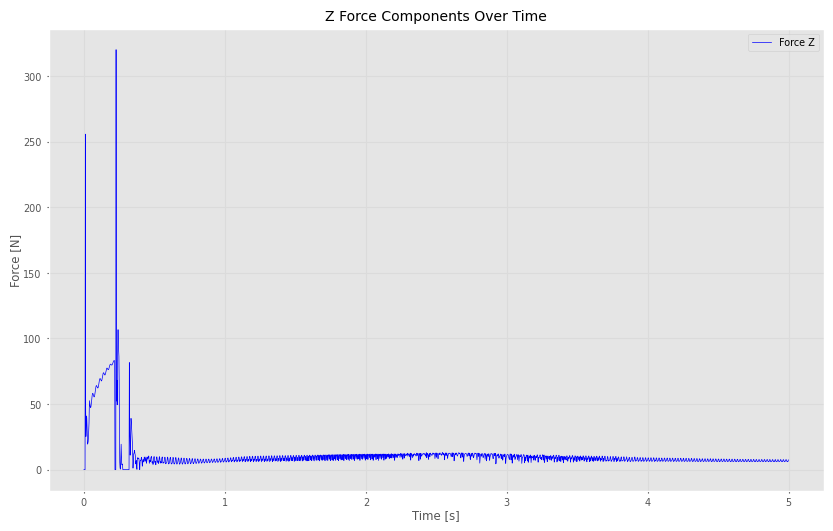

"\nplt.figure(figsize=(10, 6))\nplt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')\nplt.xlabel('Time [s]')\nplt.ylabel('Force Magnitude [N]')\nplt.title('Contact Force Magnitude Over Time')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [ ]:
# Convert logs to NumPy arrays
time_log = np.array(time_log)          # shape: (n_steps,)
force_log = np.array(force_log)        # shape: (n_steps, 3)

# Optionally, compute the overall magnitude of the force vector at each step
force_magnitude = np.linalg.norm(force_log, axis=1)
plt.figure(figsize=(10, 6))
#plt.plot(time_log, force_log[:, 0], label='Force X', color='r')
#plt.plot(time_log, force_log[:, 1], label='Force Y', color='g')
plt.plot(time_log, force_log[:, 2], label='Force Z', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Z Force Components Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')
plt.xlabel('Time [s]')
plt.ylabel('Force Magnitude [N]')
plt.title('Contact Force Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''

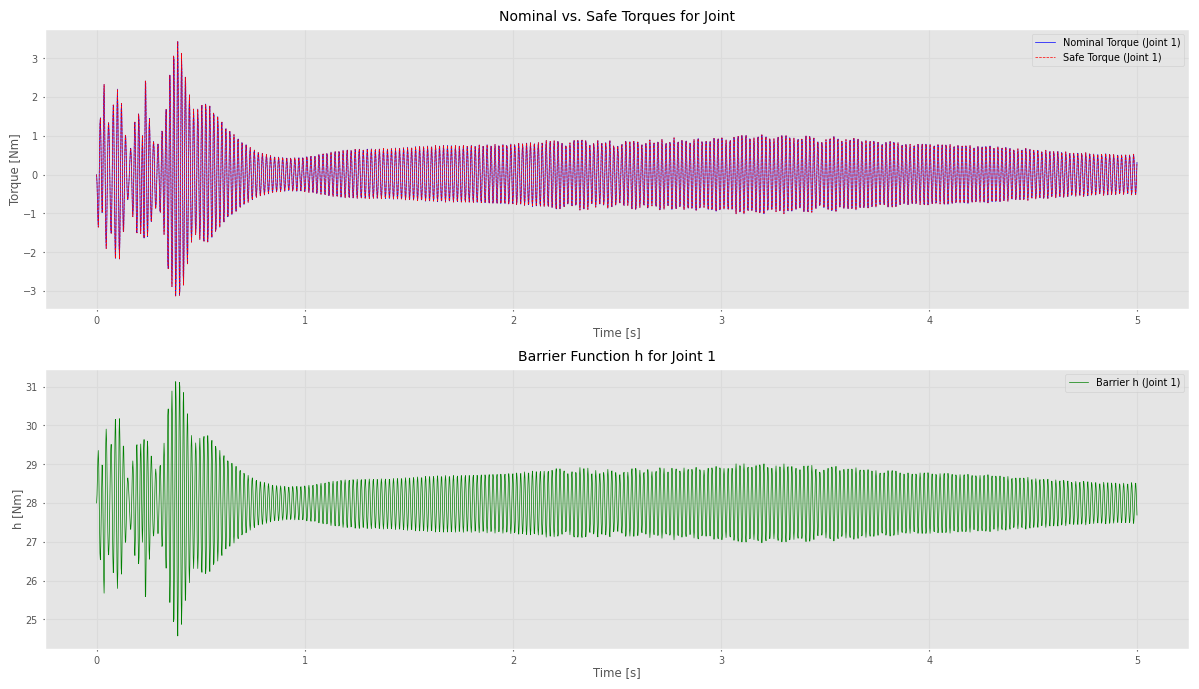

In [ ]:

time_array = np.array(time_log)

plt.figure(figsize=(12, 10))
joint = 5
# Plot nominal vs. safe torques for Joint 1 (index 0)
plt.subplot(3, 1, 1)
plt.plot(time_array, tau_nom_log[:, joint], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_cbf_log[:, joint], 'r--', label='Safe Torque (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. Safe Torques for Joint')
plt.legend()
plt.grid(True)

# Plot barrier function h for Joint 1: h = MAX_TORQUE - τ_safe.
plt.subplot(3, 1, 2)
plt.plot(time_array, h_log[:, joint], 'g-', label='Barrier h (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('h [Nm]')
plt.title('Barrier Function h for Joint 1')
plt.legend()
plt.grid(True)

# Plot the actual joint positions for Joint 1 (from q_log).
#plt.subplot(3, 1, 3)
#plt.plot(time_array, q_log[:, joint], 'k-', label='Joint 1 Position (Actual)')
#plt.xlabel('Time [s]')
#plt.ylabel('Position [rad or m]')
#plt.title('Actual Joint 1 Position Over Time')
#plt.legend()
#plt.grid(True)

plt.tight_layout()
plt.show()

##### Position plot


##### Force plot


##### Joint pos plot

##### Debug

In [ ]:
import numpy as np
import mujoco
from cvxopt import matrix, solvers
from tqdm import tqdm

# --- Set cvxopt options ---
solvers.options['show_progress'] = False

# -------------------------------------------------------------------
# Admittance Controller Parameters (Cartesian)
# -------------------------------------------------------------------
M_diag = np.array([50.0, 50.0, 50.0, 2.0, 2.0, 2.0])  # Mass matrix for admittance control
D_diag = np.array([500, 500, 500, 50, 50, 50])            # Damping matrix
K_diag = np.array([100, 100, 100, 25, 25, 25])             # Stiffness for trajectory tracking

M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

# -------------------------------------------------------------------
# (We no longer impose joint torque bounds; instead we limit the end‐effector force)
# Define force limits for the z-direction at the end effector.
F_max = 10.0    # Maximum force (N) in the z-direction
F_min = -10.0   # Minimum force (N) in the z-direction

# -------------------------------------------------------------------
# Other Parameters and Logging Setup
# -------------------------------------------------------------------
time_log = []
force_log = []  # to store the first 3 components of the external force
duration = 5        # seconds
framerate = 30      # Hz
stepsize = ur5e.m.opt.timestep  # Simulation time step (Δt)
n_steps = int(np.ceil(duration / stepsize))
showVideo = True
f_z_nom_log = []
f_z_safe_log = []

# Logging arrays
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 6))
torques = np.zeros((n_steps, 6))        # safe torques (after QP)
tau_nom_log = np.zeros((n_steps, 6))      # nominal torques (before QP)
# We log a “barrier” measure here as the difference between the limit and the computed force.
f_z_log = np.zeros(n_steps)             # log of f_z = j_z * tau_safe
q_log = np.zeros((n_steps, 6))          # actual joint positions
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []

# -------------------------------------------------------------------
# Trajectory Generation (Sinusoidal in X, constant downward in Z)
# -------------------------------------------------------------------
trajectory_amplitude = 0.03
trajectory_frequency = 0.1
z_velocity = -0.05  # Constant downward velocity
p = np.zeros((n_steps, 6))
dp = np.zeros((n_steps, 6))
ddp = np.zeros((n_steps, 6))

for i in range(n_steps):
    t = i * stepsize
    p[i, 0] = trajectory_amplitude * np.sin(2 * np.pi * trajectory_frequency * t)  # X motion
    dp[i, 0] = trajectory_amplitude * 2 * np.pi * trajectory_frequency * np.cos(2 * np.pi * trajectory_frequency * t)
    ddp[i, 0] = -trajectory_amplitude * (2 * np.pi * trajectory_frequency) ** 2 * np.sin(2 * np.pi * trajectory_frequency * t)
    
    p[i, 2] = z_velocity * t  # Downward motion in Z
    dp[i, 2] = z_velocity
    ddp[i, 2] = 0  # Constant velocity in Z means zero acceleration

# -------------------------------------------------------------------
# Reset MuJoCo Simulation and Set Initial Configuration
# -------------------------------------------------------------------
# (Assuming sol.q contains your initial joint configuration.)
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # 1. Get Cartesian kinematics: end-effector pose, Jacobian, and its derivative.
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    
    # 2. Get force at the end effector (if any).
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    # For this example we assume no additional scaling.
    
    # 3. Compute trajectory error in Cartesian space.
    target_pose = p[idx]
    error_in_base_frame = target_pose - np.concatenate([tcp_pos.t, np.zeros(3)])
    v_e = J @ ur5e.d.qvel
    
    # 4. Admittance control: compute desired Cartesian acceleration.
    acc_e = np.linalg.inv(M) @ (-D @ (v_e - dp[idx]) - K @ error_in_base_frame + ddp[idx])
    
    # 5. Compute nominal joint torques via inverse dynamics.
    tau = J.T @ (M @ acc_e + D @ (dp[idx] - v_e) + K @ error_in_base_frame)
    mass_matrix = np.zeros((ur5e.m.nv, ur5e.m.nv))
    mujoco.mj_fullM(ur5e.m, mass_matrix, ur5e.d.qM)
    coriolis_forces = ur5e.d.qfrc_bias.copy()
    tau += mass_matrix @ ur5e.d.qacc + coriolis_forces
    tau_nom = tau.copy()  # nominal torque command
    tau_nom_log[idx, :] = tau_nom.copy()
    
    # 6. Enforce force limits in the z-direction via QP.
    # We want the resulting end-effector force in z, f_z = j_z * τ, to satisfy:
    #    F_min <= j_z * τ <= F_max.
    # Here j_z is the third row of the Jacobian.
    j_z = J[2, :]  # z-direction row
    # Form the QP that minimizes 0.5||τ - τ_nom||^2 subject to:
    #    j_z * τ <= F_max   and   -j_z * τ <= -F_min.
    P = matrix(np.eye(6))
    q_vec = matrix(-tau_nom)
    G = matrix(np.vstack((j_z, -j_z)))
    h_vec = matrix(np.array([F_max, -F_min]))
    sol_qp = solvers.qp(P, q_vec, G, h_vec)
    tau_safe = np.array(sol_qp['x']).flatten()
    # Log the safe torque command
    tau_cbf_log[idx, :] = tau_safe.copy()
    
    # 7. Compute the resulting force in the z-direction.
    f_z = j_z.dot(tau_safe)
    
    #j_z = J[2, :]                # z-row of the Jacobian
    f_z_nom = j_z.dot(tau_nom)   # nominal z-force
    f_z_safe = j_z.dot(tau_safe) # safe z-force after QP filtering
    f_z_nom_log.append(f_z_nom)
    f_z_safe_log.append(f_z_safe)
    # Log a barrier-like measure (e.g., how far we are from F_max)
    # Here, if f_z == F_max then we're at the limit.
    # We log h_force = F_max - f_z.
    h_val = F_max - f_z
    h_log[idx, :] = h_val  # for simplicity, log same value for all joints
    
    # 8. Apply the safe torque command.
    ur5e.d.ctrl[:] = tau_safe
    
    # 9. Log kinematics and joint positions.
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate((tcp_pos.t, tcp_pos.rpy(order='xyz')))
    velocities[idx] = v_e
    forces[idx] = M @ acc_e
    q_log[idx, :] = ur5e.d.qpos.copy()
    
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # 10. Capture video frame (if needed)
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    # 11. Step the simulation.
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

if showVideo:
    media.show_video(frames, fps=framerate)

# -------------------------------------------------------------------
# Plotting Results for Joint 1 (extendable to other joints)
# -------------------------------------------------------------------
'''import matplotlib.pyplot as plt
time_array = np.array(time_log)

plt.figure(figsize=(12, 12))
joint = 0  # for example, plot data for Joint 1

# Plot nominal vs. safe torques for Joint 1
plt.subplot(3, 1, 1)
plt.plot(time_array, tau_nom_log[:, joint], 'b-', label='Nominal Torque (Joint 1)')
plt.plot(time_array, tau_cbf_log[:, joint], 'r--', label='Safe Torque (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.title('Nominal vs. Safe Torques for Joint 1')
plt.legend()
plt.grid(True)

# Plot barrier function h for Joint 1: here h = F_max - (j_z * τ_safe)
plt.subplot(3, 1, 2)
plt.plot(time_array, h_log[:, joint], 'g-', label='Barrier h (Joint 1)')
plt.xlabel('Time [s]')
plt.ylabel('h [N]')
plt.title('Barrier Function h for Joint 1 (Force Constraint)')
plt.legend()
plt.grid(True)

# Plot the actual joint positions for Joint 1.
plt.subplot(3, 1, 3)
plt.plot(time_array, q_log[:, joint], 'k-', label='Joint 1 Position (Actual)')
plt.xlabel('Time [s]')
plt.ylabel('Position [rad or m]')
plt.title('Actual Joint 1 Position Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
'''

TypeError: float() argument must be a string or a real number, not 'IKSolution'

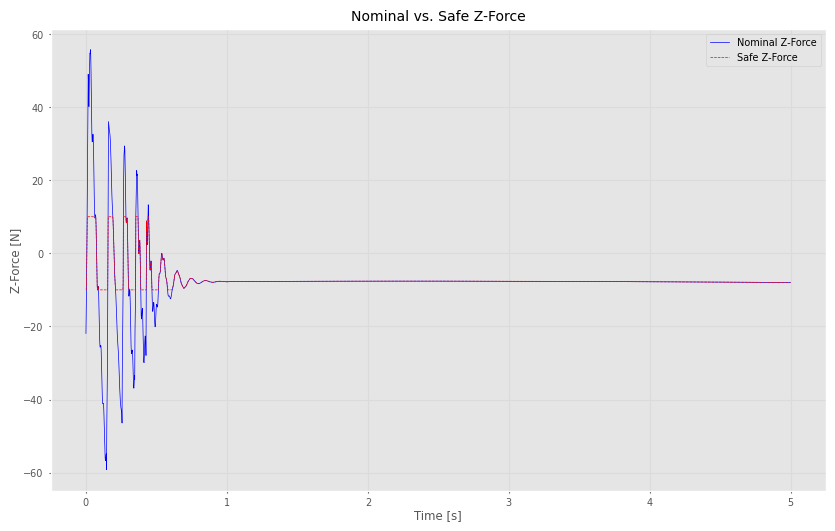

In [ ]:
# Plot nominal vs. safe z-forces
plt.figure(figsize=(10, 6))
plt.plot(time_log, f_z_nom_log, 'b-', label='Nominal Z-Force')
plt.plot(time_log, f_z_safe_log, 'r--', label='Safe Z-Force')
plt.xlabel('Time [s]')
plt.ylabel('Z-Force [N]')
plt.title('Nominal vs. Safe Z-Force')
plt.legend()
plt.grid(True)
plt.show()

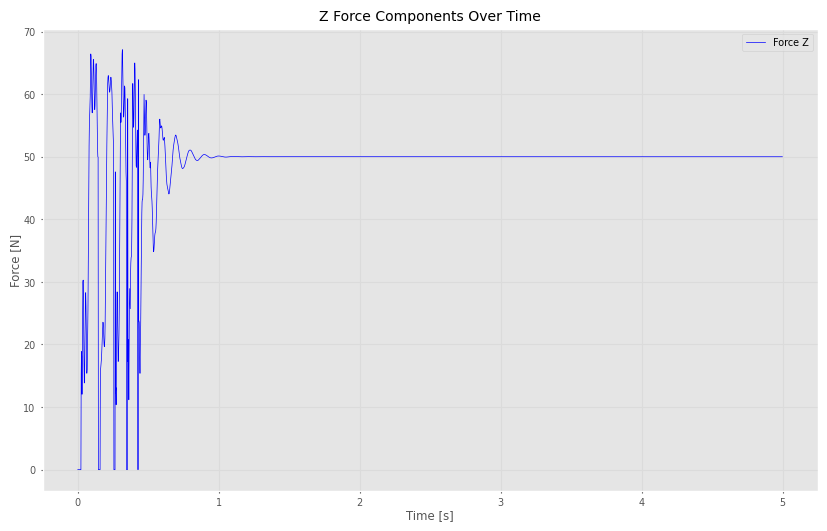

"\nplt.figure(figsize=(10, 6))\nplt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')\nplt.xlabel('Time [s]')\nplt.ylabel('Force Magnitude [N]')\nplt.title('Contact Force Magnitude Over Time')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [ ]:
# Convert logs to NumPy arrays
time_log = np.array(time_log)          # shape: (n_steps,)
force_log = np.array(force_log)        # shape: (n_steps, 3)

# Optionally, compute the overall magnitude of the force vector at each step
#force_magnitude = np.linalg.norm(force_log, axis=1)
plt.figure(figsize=(10, 6))
#plt.plot(time_log, force_log[:, 0], label='Force X', color='r')
#plt.plot(time_log, force_log[:, 1], label='Force Y', color='g')
plt.plot(time_log, force_log[:, 2], label='Force Z', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Z Force Components Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')
plt.xlabel('Time [s]')
plt.ylabel('Force Magnitude [N]')
plt.title('Contact Force Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''

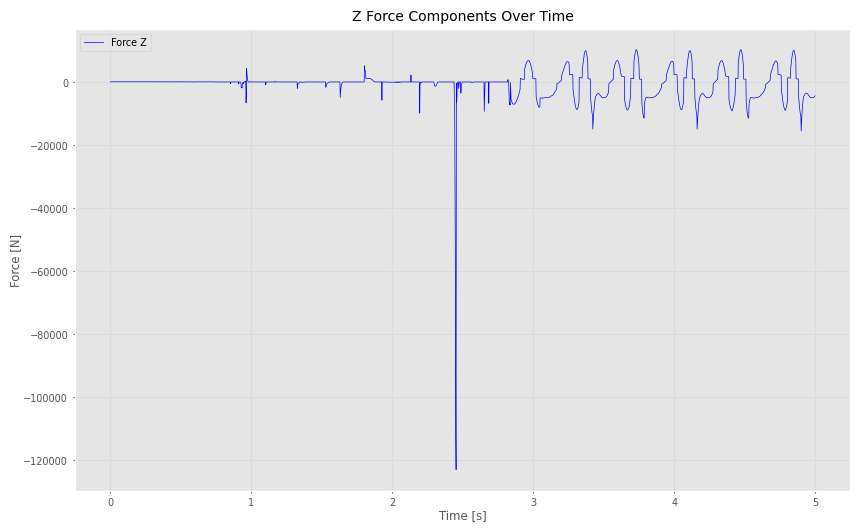

"\nplt.figure(figsize=(10, 6))\nplt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')\nplt.xlabel('Time [s]')\nplt.ylabel('Force Magnitude [N]')\nplt.title('Contact Force Magnitude Over Time')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [ ]:
# Convert logs to NumPy arrays
time_log = np.array(time_log)          # shape: (n_steps,)
force_log = np.array(force_log)        # shape: (n_steps, 3)

# Optionally, compute the overall magnitude of the force vector at each step
force_magnitude = np.linalg.norm(force_log, axis=1)
plt.figure(figsize=(10, 6))
#plt.plot(time_log, force_log[:, 0], label='Force X', color='r')
#plt.plot(time_log, force_log[:, 1], label='Force Y', color='g')
plt.plot(time_log, force_log[:, 2], label='Force Z', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Z Force Components Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''
plt.figure(figsize=(10, 6))
plt.plot(time_log, force_magnitude, label='Force Magnitude', color='k')
plt.xlabel('Time [s]')
plt.ylabel('Force Magnitude [N]')
plt.title('Contact Force Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()
'''

In [ ]:
import numpy as np
import mujoco
from tqdm import tqdm

# Define Admittance Control Matrices
M_diag = np.array([50.0, 50.0, 50.0, 20.0, 20.0, 20.0])  
D_diag = np.array([100, 100, 100, 50, 50, 50])  
K_diag = np.array([100, 100, 100, 50, 50, 50])  

M = np.diag(M_diag)
D = np.diag(D_diag)
K = np.diag(K_diag)

MAX_TORQUE = np.array([150.0, 150.0, 150.0, 28.0, 28.0, 28.0])
FZ_MAX = -5.0  # Maximum 5N along z

time_log = []
force_log = []  # to store the first 3 components of the external force
duration = 5  # seconds
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep
n_steps = int(np.ceil(duration / stepsize))
showVideo = True

# Logging and video capture
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 6))
torques = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
contact_points = []
contact_forces = []

# Generate a sinusoidal trajectory with downward motion
trajectory_amplitude = 0.04
trajectory_frequency = 0.1
z_velocity = -0.05  # Constant downward velocity
p = np.zeros((n_steps, 6))
dp = np.zeros((n_steps, 6))
ddp = np.zeros((n_steps, 6))

for i in range(n_steps):
    t = i * stepsize
    # X motion
    p[i, 0] = trajectory_amplitude * np.sin(2 * np.pi * trajectory_frequency * t)
    dp[i, 0] = (trajectory_amplitude * 2 * np.pi * trajectory_frequency 
                * np.cos(2 * np.pi * trajectory_frequency * t))
    ddp[i, 0] = -trajectory_amplitude * (2 * np.pi * trajectory_frequency)**2 \
                * np.sin(2 * np.pi * trajectory_frequency * t)
    # Z motion (downward)
    p[i, 2] = z_velocity * t
    dp[i, 2] = z_velocity
    ddp[i, 2] = 0  # constant velocity → zero accel

# Reset MuJoCo Simulation
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)

progress_bar = tqdm(total=duration)
idx = 0

while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)
    
    # 1) Forward kinematics and Jacobians
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)

    # 2) External force from contact
    f_ext = np.zeros(6)
    contact_points, contact_forces, _, _, _ = ur5e.get_contact_info()
    if len(contact_forces):
        f_ext[:3] = contact_forces[0]
    
    # 3) Trajectory error in base frame
    target_pose = p[idx]               # desired [x, y, z, rx, ry, rz]
    current_pose = np.concatenate([tcp_pos.t, np.zeros(3)])  # ignoring orientation error
    error_in_base_frame = target_pose - current_pose
    
    # 4) Actual end-effector velocity (base frame)
    v_e = J @ ur5e.d.qvel
    error_vel = v_e - dp[idx]

    # 5) Admittance: desired Cartesian acceleration
    acc_e = np.linalg.inv(M) @ (-D @ error_vel - K @ error_in_base_frame + ddp[idx])
    
    # 6) Convert desired Cartesian wrench → joint torques
    #    We'll also add standard inverse dynamics terms (mass_matrix @ qacc + coriolis).
    #    The simplest approach is: tau_nom = J^T * (M*acc_e + D*error_vel + K*error_in_base_frame)
    tau_nom = J.T @ (M @ acc_e + D @ error_vel + K @ error_in_base_frame)

    # 7) Add full joint-space mass/coriolis terms
    mass_matrix = np.zeros((ur5e.m.nv, ur5e.m.nv))
    mujoco.mj_fullM(ur5e.m, mass_matrix, ur5e.d.qM)
    coriolis_forces = ur5e.d.qfrc_bias.copy()
    tau_nom += mass_matrix @ ur5e.d.qacc + coriolis_forces

    # -----------------------
    #  CBF STEP: clamp z-force to <= 5 N
    # -----------------------
    j_z = J[2, :]                   # the z-row of the Jacobian
    Fz_nom = j_z.dot(tau_nom)       # predicted z-force
    if Fz_nom > FZ_MAX:
        # Project tau_nom onto the hyperplane j_z^T tau = FZ_MAX
        norm_jz_sq = j_z.dot(j_z)
        if norm_jz_sq > 1e-9:
            excess = (Fz_nom - FZ_MAX) / norm_jz_sq
            tau_nom -= excess * j_z
    # (If you need a constraint Fz >= -5, adjust signs accordingly.)

    # 8) Clamp torques to hardware limits
    tau_cmd = np.clip(tau_nom, -MAX_TORQUE, MAX_TORQUE)
    
    # 9) Apply torque control
    ur5e.d.ctrl[:] = tau_cmd
    
    # 10) Logging
    quat_e = r2q(tcp_pos.R)
    positions_as_quat[idx] = np.concatenate((tcp_pos.t, quat_e))
    positions_as_rpy[idx] = np.concatenate([tcp_pos.t, tcp_pos.rpy(order='xyz')])
    velocities[idx] = v_e
    forces[idx] = M @ acc_e
    torques[idx] = tau_cmd
    target_positions_as_quat[idx] = positions_as_quat[idx]
    target_positions[idx] = positions_as_rpy[idx]
    target_velocities[idx] = velocities[idx]
    time_log.append(ur5e.d.time)
    force_log.append(f_ext[:3])
    
    # 11) Capture video frames
    if len(frames) < ur5e.d.time * framerate:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    
    # 12) Step simulation
    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

progress_bar.close()

# Show video
if showVideo and len(frames) > 0:
    media.show_video(frames, fps=framerate)


 43%|████▎     | 2.1699999999999826/5 [00:22<00:29, 10.47s/it]


100%|█████████▉| 4.999999999999671/5 [00:08<00:00,  1.70s/it] 
